<a href="https://colab.research.google.com/github/jatin0jha/Image-Generating-Diffusion-Models-on-Single-Board-Computers/blob/main/image_gen_model_v_3_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check the GPU

!nvidia-smi

Mon Oct 30 08:45:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install dependencies

!git clone --recursive https://github.com/crowsonkb/v-diffusion-pytorch
%pip install git+https://github.com/crowsonkb/k-diffusion

Cloning into 'v-diffusion-pytorch'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 168 (delta 87), reused 77 (delta 62), pack-reused 55
Receiving objects: 100% (168/168), 35.25 KiB | 1.30 MiB/s, done.
Resolving deltas: 100% (103/103), done.
  Cloning https://github.com/crowsonkb/k-diffusion to /tmp/pip-req-build-nz0ogyzl
  Running command git clone --filter=blob:none --quiet https://github.com/crowsonkb/k-diffusion /tmp/pip-req-build-nz0ogyzl
  Resolved https://github.com/crowsonkb/k-diffusion to commit 045515774882014cc14c1ba2668ab5bad9cbf7c0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.0 MB/s eta 0:00:00
     

In [ ]:
# Download the diffusion model

!mkdir v-diffusion-pytorch/checkpoints
!curl -L --http1.1 https://the-eye.eu/public/AI/models/v-diffusion/cc12m_1_cfg.pth > v-diffusion-pytorch/checkpoints/cc12m_1_cfg.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2300M  100 2300M    0     0  9415k      0  0:04:10  0:04:10 --:--:-- 6969k


In [ ]:
# Imports

import gc
import math
import sys

import clip
from IPython import display
import k_diffusion as K
import torch
from torch import nn
from torchvision import utils
from torchvision.transforms import functional as TF
from tqdm.notebook import trange, tqdm

sys.path.append('/content/v-diffusion-pytorch')

from diffusion import get_model

In [ ]:
# Load the models

inner_model = get_model('cc12m_1_cfg')()
_, side_y, side_x = inner_model.shape
inner_model.load_state_dict(torch.load('v-diffusion-pytorch/checkpoints/cc12m_1_cfg.pth', map_location='cpu'))
inner_model = inner_model.half().cuda().eval().requires_grad_(False)
model = K.external.VDenoiser(inner_model)
clip_model = clip.load(inner_model.clip_model, jit=False, device='cpu')[0]

100%|████████████████████████████████████████| 351M/351M [00:01<00:00, 187MiB/s]


In [ ]:
#@title Settings

#@markdown The text prompt
prompt = 'New York City, oil on canvas'  #@param {type:"string"}

#@markdown The strength of the text conditioning (0 means don't condition on text, 1 means sample images that match the text about as well as the images match the text captions in the training set, 3+ is recommended).
weight = 5  #@param {type:"number"}

#@markdown Sample this many images.
n_images = 4  #@param {type:"integer"}

#@markdown Specify the number of diffusion timesteps (default is 50, can lower for faster but lower quality sampling).
steps =   50#@param {type:"integer"}

#@markdown The random seed. Change this to sample different images.
seed = 0  #@param {type:"integer"}

#@markdown Display progress every this many timesteps.
display_every =   10#@param {type:"integer"}

  0%|          | 0/50 [00:00<?, ?it/s]

Step 0 of 50, sigma 160:


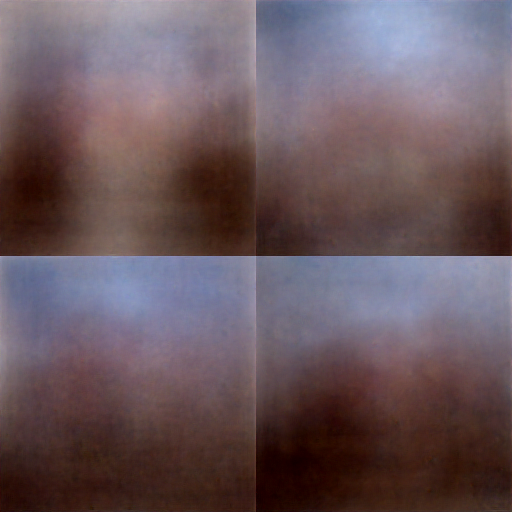


Step 10 of 50, sigma 50.0848:


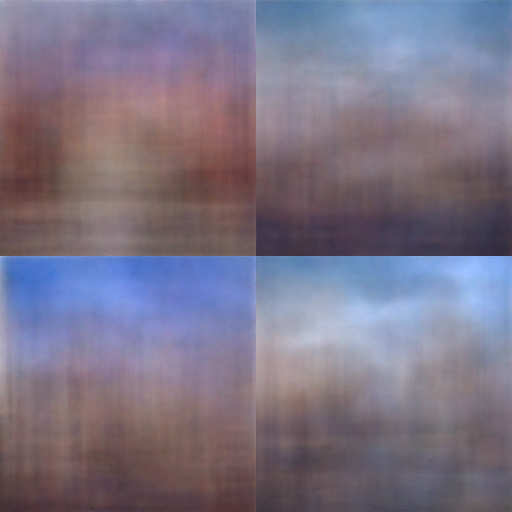


Step 20 of 50, sigma 12.4342:


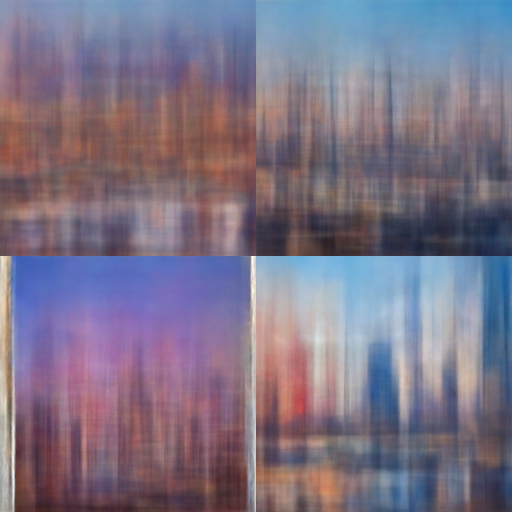


Step 30 of 50, sigma 2.17965:


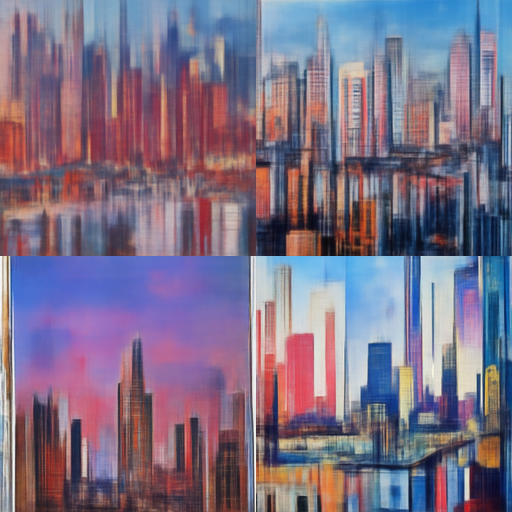


Step 40 of 50, sigma 0.213524:


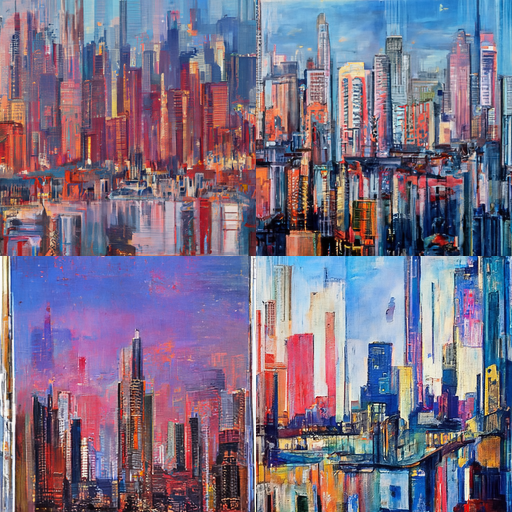


Done!


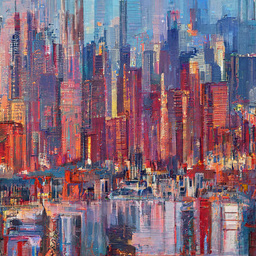

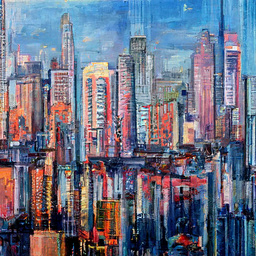

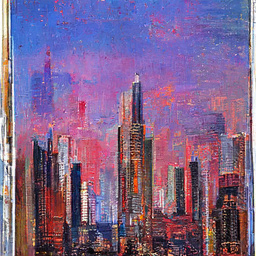

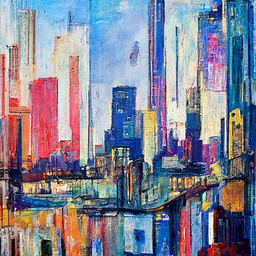

In [ ]:
target_embed = clip_model.encode_text(clip.tokenize(prompt)).float().cuda()


class CFGDenoiser(nn.Module):
    def __init__(self, model, cond_scale):
        super().__init__()
        self.inner_model = model
        self.cond_scale = cond_scale

    def forward(self, x, sigma, clip_embed):
        x_in = torch.cat([x] * 2)
        sigma_in = torch.cat([sigma] * 2)
        clip_embed_in = torch.cat([torch.zeros_like(clip_embed), clip_embed])
        uncond, cond = self.inner_model(x_in, sigma_in, clip_embed=clip_embed_in).chunk(2)
        return uncond + (cond - uncond) * self.cond_scale


def callback(info):
    if info['i'] % display_every == 0:
        nrow = math.ceil(info['denoised'].shape[0] ** 0.5)
        grid = utils.make_grid(info['denoised'], nrow, padding=0)
        tqdm.write(f'Step {info["i"]} of {steps}, sigma {info["sigma"]:g}:')
        display.display(K.utils.to_pil_image(grid))
        tqdm.write(f'')


def run():
    gc.collect()
    torch.cuda.empty_cache()
    torch.manual_seed(seed)
    sigmas = K.sampling.get_sigmas_karras(steps, 1e-2, 160, device='cuda')
    x = torch.randn([n_images, 3, side_y, side_x], device='cuda') * sigmas[0]
    model_wrap = CFGDenoiser(torch.cuda.amp.autocast()(model), weight)
    extra_args = {'clip_embed': target_embed.repeat([n_images, 1])}
    outs = K.sampling.sample_lms(model_wrap, x, sigmas, extra_args=extra_args, callback=callback)
    tqdm.write('Done!')
    for i, out in enumerate(outs):
        filename = f'out_{i}.png'
        K.utils.to_pil_image(out).save(filename)
        display.display(display.Image(filename))


run()